## Customer Segmentation using Online Retail Store dataset

### Introduction

For week 8 journal entry, I decided to explore customer segmentation using Online Retail Store dataset (http://archive.ics.uci.edu/ml/datasets/online+retail) from UCI machine learning repository. 

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

My analysis is primarily focused on the customers from United Kingdom as they are maximum in number.

The goal of this work is two fold:
* Perform RFM analysis which is a proven marketing tool for behavior based customer segmentation (https://www.putler.com/rfm-analysis/).


* Combine RFM analysis with unsupervised clustering techniques to help the marketing teams of online retail business understand:
  + their most valued customers in terms of revenue.
  + which customers are more likely to respond to promotional campaigns?
  + which customers can be retained? etc...
  
  

Numpy,Pandas and Sklearn libraries have been used to perform data preprocessing and clustering. 

The performance of the clustering models have been measured using Silhouette scores from sklearns's metrics module.

The data mining steps to prepare the data to be fed into the model, exploratory data analysis, RFM(recency, frequency and monetary)analysis, data normalization,modeling/evaluation of clustering techniques  constitute the experience of this project.

In [107]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import datetime as dt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

### Data Preprocessing 

In [2]:
# Load the dataset.
retaildf = pd.read_excel('Online Retail.xlsx')

Take a quick look at the data set!!!

In [3]:
retaildf.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Look at the schema of the dataset.
retaildf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Quite  a few missing values in CustomerID, and Description columns....But let's check which country has the highest no. of online customers first....

In [6]:
print "No. of countries :",retaildf['Country'].nunique()

 No. of countries : 38


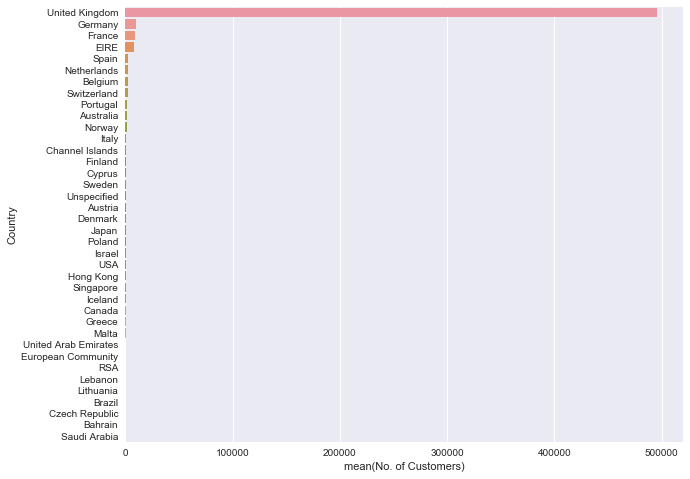

In [7]:
# Visualizing the countries with highest no. of online customers.
country=retaildf['Country'].value_counts()
country =pd.DataFrame(country)
country.reset_index(inplace=True)
country.columns =['Country','No. of Customers']
fig,ax = plt.subplots(figsize=(10,8))
sns.barplot(x ='No. of Customers', y ='Country', data=country)

United Kingdom has the highest no. of customers. So, I would like to focus my analysis on United Kingdom customers only.

In [8]:
# Cull the data for UK customers.
retaildata=retaildf[retaildf['Country'] == 'United Kingdom']

Quantity is an important variable in evaluating the monetary value of a customer. So, look at the statistics for this column..

In [9]:
# Describe quatity column
retaildata['Quantity'].describe()

count    495478.000000
mean          8.605486
std         227.588756
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

Negative values in Quantity column means it is a cancelled order. It is mentioned in the dataset description that cancelled orders has their invoices starting with "C". Let's validate that before performing any analysis.

In [10]:
# Look at cancelled orders
cancelledOrders = retaildata[retaildata['InvoiceNo'].astype(str).str.contains('C')]
cancelledOrders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Cancelled orders do have their invoice numbers starting with letter "C" and also have negative values in the quantity column. Let' confirm if they have any positive quantity at all...

In [11]:
# Validate cancelled orders...
cancelledOrders[cancelledOrders['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Alright!!! so, negative quantity might mean that the transaction corresponds to cancelled orders. Let's cull the data for positive quantities.

In [12]:
# extract the data for quantity greater than 1
retaildata=retaildata[retaildata['Quantity']>0]

Now, let's handle missing values. There are quite a few missing values in CustomerID and description column...

In [13]:
retaildata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486286 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      486286 non-null object
StockCode      486286 non-null object
Description    485694 non-null object
Quantity       486286 non-null int64
InvoiceDate    486286 non-null datetime64[ns]
UnitPrice      486286 non-null float64
CustomerID     354345 non-null float64
Country        486286 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.4+ MB


In [14]:
# drop rows with missing values in customer column
retaildata.dropna(subset=['CustomerID'],inplace=True)
retaildata.shape

(354345, 8)

It is mentioned in the description that dataset contains transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.So, I would use the data for one year from 09/12/2010 to 09/12/2011.

In [15]:
# Extract the data from 2010-12-09 onwards....
retaildata= retaildata[retaildata['InvoiceDate']>="2010-12-09"]

In [16]:
# Check out the rows and columns in the extracted data
retaildata.shape

(342478, 8)

In [17]:
# Schema
retaildata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342478 entries, 19632 to 541893
Data columns (total 8 columns):
InvoiceNo      342478 non-null object
StockCode      342478 non-null object
Description    342478 non-null object
Quantity       342478 non-null int64
InvoiceDate    342478 non-null datetime64[ns]
UnitPrice      342478 non-null float64
CustomerID     342478 non-null float64
Country        342478 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 23.5+ MB


No missing values....

In [18]:
print "No. of unique transactions in dataset :", retaildata['InvoiceNo'].nunique()
print "No. of unique products bought :", retaildata['StockCode'].nunique()
print "No. of customers :", retaildata['CustomerID'].nunique()

No. of unique transactions in dataset : 16017
No. of unique products bought : 3611
No. of customers : 3863


### Methods

RFM analysis and clustering techniques will be combined in the mini project to perform customer segmentation. 

RFM analysis will prepare the data in context of recency, frequency and monetary value of the customer. Later, various clustering algorithms like Kmeans and Gaussian Mixture Models will be applied on the RFM data to identify the customer groups in terms of their value etc...

#### Step 1: RFM Analysis

In marketing domain, RFM (Recency, Frequency, Monetary) is a very popular technique to perform customer segmentation that uses the past buying behavior of customers to segregate them into groups.

It helps to indentify the customers who will most likely respond to a promotion or any personalization services in future.

* Recency : No. of days passed since last purchase by the customer.
* Frequency : Total no. of purchase transactions by the customer.
* Monetary : Total money spent by the customer.


In order to perform RMF analysis, one needs to create the above mentioned three attributes for every customer in the dataset.

#### Recency

Recency tells how recent was the customer's buying transaction in the retail store.

In order to compute recency, one needs to select a date from which one may calculate the no. of days passed since the customer last bought any product from the online retail store.

Let's look at the last invoice date in the dataset.

In [19]:
print "Last date in the dataset: ", retaildata['InvoiceDate'].max()

Last date in the dataset:  2011-12-09 12:49:00


Let's go ahead and use 09/12/2011 as the reference point.

In [280]:
datept = dt.date(2011,12,9)
print datept

2011-12-09


In [21]:
# Create a column date that contains invoice date
retaildata['date'] = retaildata['InvoiceDate'].dt.date

In [23]:
retaildata.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09


Now, let's compute the no. of days passed since the customer last bought any product from the online retail store using 09/12/2011 as the reference point.

In [25]:
#extract the last purchase date and compute the no. of days passed since then.
recency_data = retaildata.groupby('CustomerID',as_index=False)['date'].max()
recency_data.columns = ['CustomerID','LastBoughtDate']
recency_data['Recency'] = recency_data['LastBoughtDate'].apply(lambda x: (datept - x).days)
recency_data.head()

,CustomerID,LastBoughtDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [26]:
# Drop the lastboughtdate column
recency_data.drop('LastBoughtDate',axis=1,inplace=True)

#### Frequency

Frequency tells how many times did the customer buy products from the retail store. Let's check the no. of invoices registered by the same customer in order to compute frequency.

Data entry errors are very common. So, let's check if there are any duplicate rows with same customer and same invoice no.

In [27]:
print "No. of duplicate rows with same customer and same invoice no. :", sum(retaildata.duplicated(subset=['InvoiceNo','CustomerID']))

No. of duplicate rows with same customer and same invoice no. : 326461


Drop the duplicate rows and compute the frequency value.

In [28]:
# Make a copy of the dataset and drop duplicate rows with same customer and same invoice no. if any
retaildataCopy = retaildata
retaildataCopy.drop_duplicates(subset=['InvoiceNo','CustomerID'], keep ='first', inplace=True)
frequency_data = retaildataCopy.groupby('CustomerID',as_index=False)['InvoiceNo'].count()
frequency_data.columns = ['CustomerID','Frequency']
frequency_data.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


#### Monetary 

Monetary value tells us how much money in total did the customer spend in the retail store.

In order to compute total money spent by the customer, let's add a column 'TotalCost' in the datatset.

In [29]:
# Compute monetary value of the customers
retaildata['TotalCost'] = retaildata['Quantity']*retaildata['UnitPrice']
monetary_data = retaildata.groupby('CustomerID', as_index=False).agg({'TotalCost':'sum'})
monetary_data.columns =['CustomerID','Monetary']
monetary_data.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


Now, that all the attributes have been calculated let's merge all the data to create RFM table.

In [30]:
#Merge the Recency, frequency and monetary data together
rfm_data=recency_data.merge(frequency_data,on='CustomerID').merge(monetary_data,on='CustomerID')
rfm_data.set_index('CustomerID',inplace=True)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


From the first row of the RFM, the customer with ID "12346.0" bought a product from the retail store just once worth 77183.6 sterlings before 325 days from 09/12/2011. 

let's go ahead and validate this observation from original dataset.

In [31]:
# Data validation 
retaildata[retaildata['CustomerID']==12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.6


In [32]:
print "No. of days passed since the customer last bought from the store:", (datept - dt.date(2011,1,18)).days

No. of days passed since the customer last bought from the store: 325


Indeed the RFM table is correct....

#### Step 2: Clustering Implementation to perform customer segmentation using RFM data.

Before performing the clustering analysis, let's check out the distribution of the data.

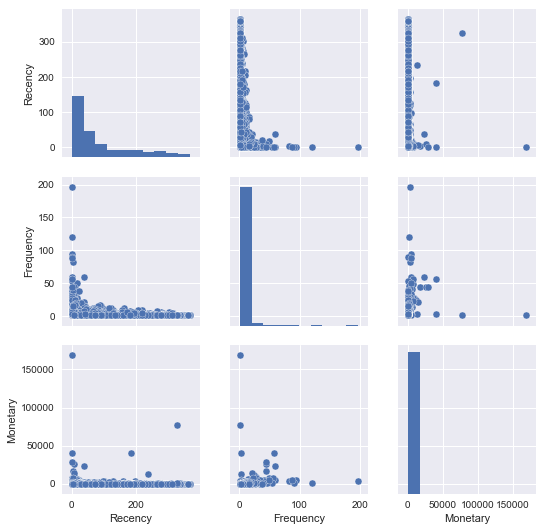

In [53]:
# Visualization to check out distribution of data
sns.pairplot(rfm_data)

RFM data is skewed positively and contains outliers as well.This is very obvious in the above pair plot.

Kmeans clustering requires data to be continuous. It works best with relatively normally distributed and standardized input variables.Moreover, standardization of input variables is very important, else input variables with larger variance will have greater influence on the results. 

So, let's perform a log transformation on the three variables in RFM data and then standardize them as z-scores.

#### Data Normalization

In [38]:
# log transformation of the dataset to transform the skewness. Cannot take log(0) and so adding a small number
recency_log = np.log(rfm_data['Recency']+0.1) 
frequency_log = np.log(rfm_data['Frequency'])
monetary_log = np.log(rfm_data['Monetary']+0.1)
log_data = pd.DataFrame({'Recency': recency_log,'Frequency': frequency_log,'Monetary': monetary_log})

In [46]:
# Standardizing the data as z scores
std_values = lambda values : (values - values.mean() )/values.std()
trans_data=log_data.apply(std_values)

In [54]:
trans_data.head()

,Frequency,Monetary,Recency
CustomerID,,,
12346.0,-1.041919,4.820041,1.390563
12747.0,1.537319,1.705525,-1.960512
12748.0,4.870355,2.840606,-3.983921
12749.0,0.760891,0.462423,-1.701671
12820.0,0.510937,0.119832,-1.701671


Let's take a quick look at how transformed data is distributed.

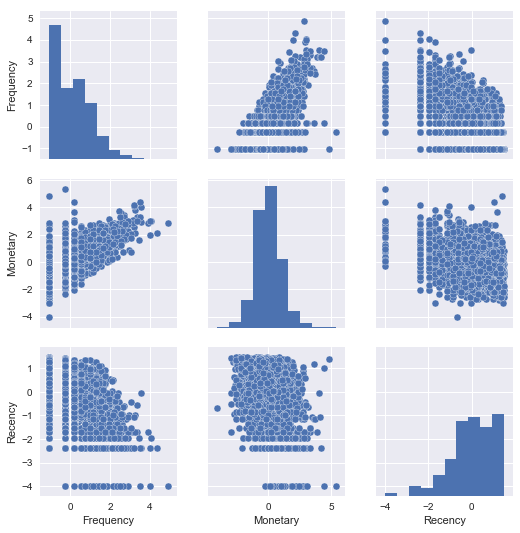

In [48]:
# Produce a scatter matrix for each pair of features in the data
sns.pairplot(trans_data)

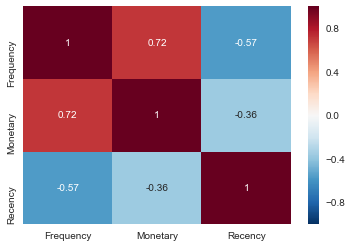

In [192]:
# Heatmap to show correlation between features
sns.heatmap(trans_data.corr(),annot=True)

The above pair plot shows that the distributions are better normalized now. The heatmap confirms the strength of positive relationship between frequency and monetary value feature i.e the more customer visits the store, the more money the customer would spend in the store. This is pretty intuitive!!!

The relationship between Recency/Monetary and Recency/Frequency is negative in nature. 


Since, the data is normalized, next step would be the implementation of clustering techniques for customer segmentation.

#### Kmean Clustering

Kmeans algorithm requires us to specify the no. of clusters k a priori. An inappropriate choice of cluster k can result in poor clustering performance. Elbow method and silhouette coefficient analysis are useful techniques to evaluate the quality of a clustering to help us determine the optimal no. of clusters k.

#### Identifying No. of Clusters using Silhouette Coefficient Analysis:

Silhouette score is a measure of cluster cohesion between points in the same cluster and cluster separation between the points from different clusters. This value is bounded in the range -1 to 1. A silhouette score of 0 means cluster cohesion and cluster separation are equal. Furthermore, we get close to an ideal score of 1 if cluster separation >>  cluster cohesion. 


In [94]:
# Cluster analysis using silhouette scores
inMatrix = trans_data.as_matrix()
for k in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = k, n_init=100, max_iter=300)
    kmeans.fit(inMatrix)
    cluster_predictions = kmeans.predict(inMatrix)
    scores = silhouette_score(inMatrix, cluster_predictions)
    print "For n_clusters =", k , "The average silhouette_score is :", scores  
    #create a scatter plot
    plt.scatter(inMatrix[:, 0], inMatrix[:, 1], c=clusters_customers, s=50, cmap='viridis')
    #select cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

        

For n_clusters = 2 The average silhouette_score is : 0.407198517954
For n_clusters = 3 The average silhouette_score is : 0.320783448006
For n_clusters = 4 The average silhouette_score is : 0.307655690066
For n_clusters = 5 The average silhouette_score is : 0.28939028622
For n_clusters = 6 The average silhouette_score is : 0.285907778578
For n_clusters = 7 The average silhouette_score is : 0.284019469121
For n_clusters = 8 The average silhouette_score is : 0.293965263621
For n_clusters = 9 The average silhouette_score is : 0.287959010029


The best silhouette score of 0.4 is obtained with no. of clusters of 2. Let's visualize couple of these clustering results and look at the median value and median frequency of visit of the customers per cluster. 

Average silhouette score with 2 clusters : 0.407


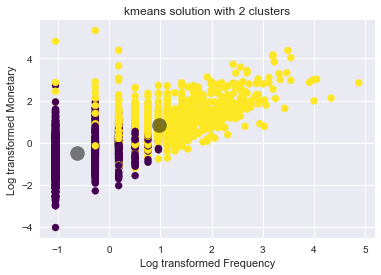

In [217]:
# Analysing clustering results
from sklearn.metrics import silhouette_score
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
kmeans.fit(trans_data)
clusters_customers = kmeans.predict(trans_data)
silhouette_score = silhouette_score(trans_data, clusters_customers)
print('Average silhouette score with 2 clusters : {:<.3f}'.format(silhouette_score))

#create a scatter plot
plt.scatter(trans_data.ix[:, 0], trans_data.ix[:, 1], c=clusters_customers, s=50, cmap='viridis')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('Log transformed Frequency')
plt.ylabel('Log transformed Monetary')
plt.title('kmeans solution with 2 clusters')

In [218]:
# Clustering results with 2 clusters
labels_true = trans_data.index
labels = kmeans.labels_

print "Results with 2 clusters :"
print "\n"

for k in range(n_clusters):
    class_members = (labels==k)
    print "Cluster no --> %d" %(k+1)
    print "No. of Customers in this cluster are : %d" %(sum(class_members))
    print labels_true[class_members]
    idx = labels_true[class_members]
    print "\n"
    print "Median Value of Customers in cluster {} is {}".format(k+1,rfm_data.ix[idx]['Monetary'].median())
    print "Median Frequency of Customers in cluster {} is {}".format(k+1,rfm_data.ix[idx]['Frequency'].median())
    print "Median Recency of Customers in cluster {} is {}".format(k+1,rfm_data.ix[idx]['Recency'].median())

    print "\n"

Results with 2 clusters :


Cluster no --> 1
No. of Customers in this cluster are : 2378
Float64Index([12821.0, 12822.0, 12824.0, 12829.0, 12831.0, 12832.0, 12833.0,
              12834.0, 12836.0, 12837.0,
              ...
              18262.0, 18265.0, 18268.0, 18270.0, 18274.0, 18276.0, 18277.0,
              18278.0, 18280.0, 18281.0],
             dtype='float64', name=u'CustomerID', length=2378)


Median Value of Customers in cluster 1 is 21.085
Median Frequency of Customers in cluster 1 is 1.0
Median Recency of Customers in cluster 1 is 88.0


Cluster no --> 2
No. of Customers in this cluster are : 1485
Float64Index([12346.0, 12747.0, 12748.0, 12749.0, 12820.0, 12823.0, 12826.0,
              12827.0, 12828.0, 12830.0,
              ...
              18245.0, 18246.0, 18257.0, 18260.0, 18263.0, 18272.0, 18273.0,
              18282.0, 18283.0, 18287.0],
             dtype='float64', name=u'CustomerID', length=1485)


Median Value of Customers in cluster 2 is 141.72
Median Freq

A two cluster solution gives one group with a higher median value(141.9 sterlings) and the other group with a lower median value (21.0 sterlings). The frequency of visits by the customers in group 1 is higher than group 2. Also, the customers in group 1 bought the products quite recently i.e they have been shopping relatively recently and more.

Kmeans with 2 cluster solution is oversimplying the user behaviour and cluster assignments do not look very discrete. So, let's look at a 3 cluster solution.

Average silhouette score with 3 clusters: 0.321


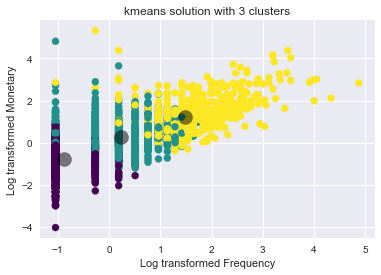

In [219]:
# Analysing clustering results
from sklearn.metrics import silhouette_score
n_clusters = 3
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
kmeans.fit(trans_data)
clusters_customers = kmeans.predict(trans_data)
silhouette_score = silhouette_score(trans_data, clusters_customers)
print('Average silhouette score with 3 clusters: {:<.3f}'.format(silhouette_score))

#create a scatter plot
plt.scatter(trans_data.ix[:, 0], trans_data.ix[:, 1], c=clusters_customers, s=50, cmap='viridis')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('Log transformed Frequency')
plt.ylabel('Log transformed Monetary')
plt.title('kmeans solution with 3 clusters')

In [220]:
# Clustering results with 3 clusters
labels_true = trans_data.index
labels = kmeans.labels_

print "Results with 3 clusters :"
print "\n"

for k in range(n_clusters):
    class_members = (labels==k)
    print "Cluster no --> %d" %(k+1)
    print "No. of Customers in this cluster are : %d" %(sum(class_members))
    print labels_true[class_members]
    idx = labels_true[class_members]
    print "\n"
    print "Median Value of Customers in cluster {} is {}".format(k+1,rfm_data.ix[idx]['Monetary'].median())
    print "Median Frequency of Customers in cluster {} is {}".format(k+1,rfm_data.ix[idx]['Frequency'].median())
    print "Median Recency of Customers in cluster {} is {}".format(k+1,rfm_data.ix[idx]['Recency'].median())

    print "\n"

Results with 3 clusters :


Cluster no --> 1
No. of Customers in this cluster are : 1605
Float64Index([12821.0, 12822.0, 12824.0, 12831.0, 12833.0, 12834.0, 12837.0,
              12838.0, 12842.0, 12844.0,
              ...
              18250.0, 18252.0, 18255.0, 18262.0, 18268.0, 18274.0, 18277.0,
              18278.0, 18280.0, 18281.0],
             dtype='float64', name=u'CustomerID', length=1605)


Median Value of Customers in cluster 1 is 15.9
Median Frequency of Customers in cluster 1 is 1.0
Median Recency of Customers in cluster 1 is 133.0


Cluster no --> 2
No. of Customers in this cluster are : 1560
Float64Index([12346.0, 12827.0, 12829.0, 12832.0, 12836.0, 12840.0, 12843.0,
              12845.0, 12849.0, 12853.0,
              ...
              18257.0, 18259.0, 18260.0, 18261.0, 18263.0, 18265.0, 18270.0,
              18276.0, 18282.0, 18287.0],
             dtype='float64', name=u'CustomerID', length=1560)


Median Value of Customers in cluster 2 is 67.19
Median Freque

In three cluster solution, group1, group2 and group3 have median values of 67.18, 258.995 and 15.9 sterlings respectively. The corresponding frequency of visits by customers in these groups are 3, 9 and 1 with corresponding recency in their visits being 39, 7, and 133 days. 

These numbers confirm that the group of customers that generate higher revenue visit more frequently and have bought more recently in the online retail store. 

Let's look at one more solution with 5 clusters...

Average silhouette score with 3 clusters: 0.290


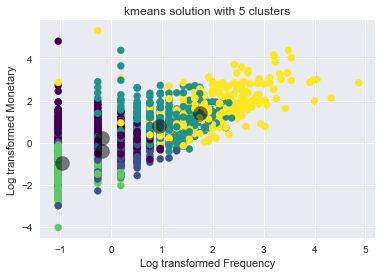

In [221]:
# Analysing clustering results
from sklearn.metrics import silhouette_score
n_clusters = 5
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
kmeans.fit(trans_data)
clusters_customers = kmeans.predict(trans_data)
silhouette_score = silhouette_score(trans_data, clusters_customers)
print('Average silhouette score with 3 clusters: {:<.3f}'.format(silhouette_score))

#create a scatter plot
plt.scatter(trans_data.ix[:, 0], trans_data.ix[:, 1], c=clusters_customers, s=50, cmap='viridis')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('Log transformed Frequency')
plt.ylabel('Log transformed Monetary')
plt.title('kmeans solution with 5 clusters')

In [222]:
# Clustering results with 5 clusters
labels_true = trans_data.index
labels = kmeans.labels_

print "Results with 5 clusters :"
print "\n"

for k in range(n_clusters):
    class_members = (labels==k)
    print "Cluster no --> %d" %(k+1)
    print "No. of Customers in this cluster are : %d" %(sum(class_members))
    print labels_true[class_members]
    idx = labels_true[class_members]
    print "\n"
    print "Median Value of Customers in cluster {} is {}".format(k+1,rfm_data.ix[idx]['Monetary'].median())
    print "Median Frequency of Customers in cluster {} is {}".format(k+1,rfm_data.ix[idx]['Frequency'].median())
    print "Median Recency of Customers in cluster {} is {}".format(k+1,rfm_data.ix[idx]['Recency'].median())

    print "\n"

Results with 5 clusters :


Cluster no --> 1
No. of Customers in this cluster are : 893
Float64Index([12346.0, 12822.0, 12829.0, 12836.0, 12840.0, 12842.0, 12845.0,
              12854.0, 12857.0, 12863.0,
              ...
              18239.0, 18240.0, 18248.0, 18251.0, 18252.0, 18261.0, 18265.0,
              18270.0, 18276.0, 18287.0],
             dtype='float64', name=u'CustomerID', length=893)


Median Value of Customers in cluster 1 is 60.9
Median Frequency of Customers in cluster 1 is 2.0
Median Recency of Customers in cluster 1 is 108.0


Cluster no --> 2
No. of Customers in this cluster are : 658
Float64Index([12820.0, 12827.0, 12832.0, 12844.0, 12849.0, 12904.0, 12920.0,
              12925.0, 12933.0, 12937.0,
              ...
              18158.0, 18174.0, 18184.0, 18188.0, 18205.0, 18217.0, 18249.0,
              18259.0, 18263.0, 18282.0],
             dtype='float64', name=u'CustomerID', length=658)


Median Value of Customers in cluster 2 is 30.22
Median Frequency 

With the increase in the no. of clusters, the graphs become increasingly hard to interpret visually and the cluster centers start to make distinction that might not be very clear. 

#### Identifying No. of Clusters using Elbow method:

In order to choose the optimal no. of clusters we can also look at elbow method that generates graph between within cluster variance on y axis and no. of clusters on x axis. 

The idea behind this technique is to identify the value of k(no. of clusters) where distortions(variance within the cluster) begin to increase more rapidly i.e the elbow point.

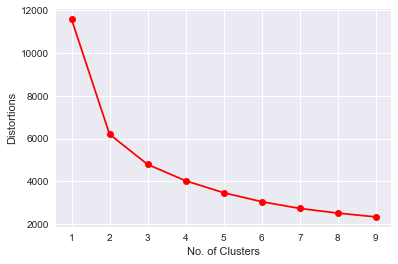

In [212]:
# Calculating with cluster SSE and generating elbow graph.

distortions = [] # within cluster SSE list calculated using km.interia_
for k in range(1,10):
    km = KMeans(init='k-means++', n_clusters = k, n_init=10, max_iter=300)
    km.fit(trans_data)
    distortions.append(km.inertia_)
    
plt.plot(range(1,10),distortions, marker='o',color='red')
plt.xlabel('No. of Clusters')
plt.ylabel('Distortions')
plt.show()

In the above plot, the elbow is located at n_clusters = 2, which gives us the evidence in favour of the goodness of the model. 

Both the elbow and silhouette method suggest 2 cluster solution. But in my opinion the 2 cluster solution with Kmeans looks over simplified. There is no clear cut separations i.e cluster assignments are quite muddled. Moreover, in kmeans there is no guarrantee of acheiving global optimal solution. It also can't deal with datasets with different shapes and does not enable probabilistic cluster assignments.

Let's check out other methods like Gaussian Mixture Method which is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.


#### Gaussian Mixture Model 

/Users/Shruti/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Shruti/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Shruti/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Shruti/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation

Average Silhouette score with 2 cluster GMM : 0.398358336308


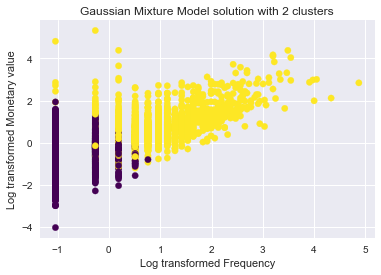

In [278]:
# Implementation of GMM using 2 clusters
gmm = GMM(n_components=2).fit(trans_data)
cluster_labels = gmm.predict(trans_data)
score = silhouette_score(trans_data,cluster_labels)
print "Average Silhouette score with 2 cluster GMM :", score
plt.scatter(trans_data.ix[:, 0], trans_data.ix[:, 1], c=cluster_labels, s=40, cmap='viridis')
plt.xlabel('Log transformed Frequency')
plt.ylabel('Log transformed Monetary value')
plt.title('Gaussian Mixture Model solution with 2 clusters')

GMM model does not perform better than kmeans. The cluster assignments are not clearly separated. The silhouette score which is measure of cluster cohesion and separation is less than kmeans solution with 2 clusters. 

Let's look at one more three cluster solution with GMM.

/Users/Shruti/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Shruti/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Shruti/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Shruti/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation

Average Silhouette score with 3 cluster GMM : 0.289043611658


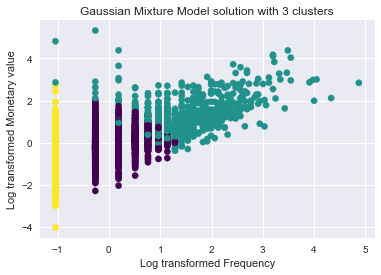

In [279]:
# Implementation of GMM using 3 clusters
gmm = GMM(n_components=3).fit(trans_data)
cluster_labels = gmm.predict(trans_data)
score = silhouette_score(trans_data,cluster_labels)
print "Average Silhouette score with 3 cluster GMM :", score
plt.scatter(trans_data.ix[:, 0], trans_data.ix[:, 1], c=cluster_labels, s=40, cmap='viridis')
plt.xlabel('Log transformed Frequency')
plt.ylabel('Log transformed Monetary value')
plt.title('Gaussian Mixture Model solution with 3 clusters')

The silhouette coefficient dropped further with 3 clusters.

### Results and Discussions: 

Kmeans and GMM are giving the same performance more or less. To be able to decide upon the most optimal no. of clusters, it would be best to consult with business stakeholders to understand the level of granularity they want to see in the cluster i.e whether they would like to see just 2 groups with clear differences in the monetary value of the customers and they would prefer more gradual low to high approach with more no. of clusters.

In this project, I worked with entire Recency, frequency, Monetary data to perform the clustering. But according to Pareto's rule in context of market segmentation, **80% of the results come from 20% of the causes.** 

Similarly, **20% customers contribute to 80% of your total revenue.** 

So, this project can be extended further in the following ways:

* By incorporating only the 20% of the customers generating 80% of the revenue by ranking the customers by their monetary value in RFM table.
* By handling outliers. Algorithms like kmeans are very sensitive to outliers. They can some times end up being clustered together in their own group. Such outlier detection might help understand most important customers to the marketing team.
* By implementing density based clustering algorithm like DBSCAN.
